In [7]:
import numpy as np
from pyscf import gto, scf, cc

nn2 = 1
s = 20
e_hf = np.zeros(nn2)
e_ccsd_t = np.zeros(nn2)

def n2(d):
    n2 = f'''
    N 0 {d} 0
    N 1.12027 {d} 0
    '''
    return n2

atoms = ''
for i in range(nn2):
    atoms += n2(i*s)

    mol = gto.M(atom=atoms, basis="sto6g", verbose=4)
    mf = scf.RHF(mol).density_fit()
    mf.kernel()
    e_hf[i] = mf.e_tot

    nfrozen = 2*(i+1)
    mycc = cc.CCSD(mf)
    mycc.kernel()
    et = mycc.ccsd_t()
    e_ccsd_t[i] = mycc.e_tot+et

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#1882-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sun Jul  6 18:45:21 2025
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.0

CPU time:        78.25


******** <class 'pyscf.df.df_jk.DFRHF'> ********
method = DFRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = False
chkfile to save SCF result = /tmp/tmpsq3k5ptj
max_memory 4000 MB (current use 265 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
******** <class 'pyscf.df.df.DF'> ********
auxbasis = None
max_memory = 4000
ETB for N: l = 0, exps = 0.3693673104 * 2^n , n = 0..12
ETB for N: l = 1, exps = 0.3693673104 * 2^n , n = 0..10
ETB for N: l = 2, exps = 0.3693673104 * 2^n , n = 0..7

WARN: Even tempered Gaussians are generated as DF auxbasis for  N

init E= -108.662027017932
  HOMO = -0.323306062182832  LUMO = 0.147026723235615
cycle= 1 E= -108.544271140947  delta_E= 0.118  |g|= 0.0424  |ddm|= 2.35
  HOMO = -0.537713174465995  LUMO = 0.261337103361037
c

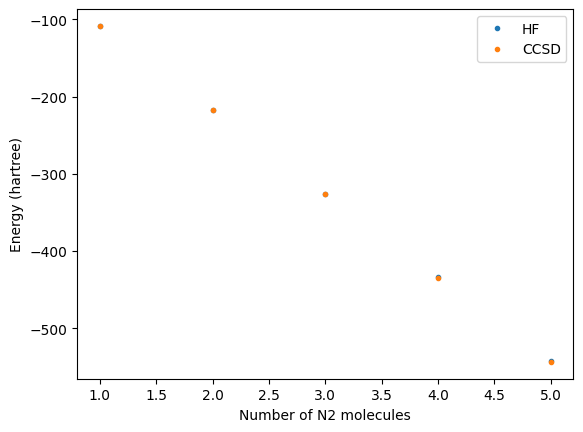

In [2]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1,nn2+1),e_hf,'.', label='HF')
plt.plot(np.arange(1,nn2+1),e_ccsd_t,'.', label='CCSD')
plt.xlabel('Number of N2 molecules')
plt.ylabel('Energy (hartree)')
plt.legend()
plt.show()

In [3]:
print('HF energy per molecule',e_hf/np.arange(1,nn2+1))
print('CCSD energy per molecule',e_ccsd_t/np.arange(1,nn2+1))

HF energy per molecule [-108.54436058 -108.54436054 -108.54436052 -108.54436051 -108.54436051]
CCSD energy per molecule [-108.70757623 -108.70757616 -108.70757614 -108.70757614 -108.70757613]


In [5]:
print('HF energy per molecule',e_hf/np.arange(1,nn2+1))
print('CCSD energy per molecule',e_ccsd_t/np.arange(1,nn2+1))

HF energy per molecule [-108.54436058 -108.54436054 -108.54436052 -108.54436051 -108.54436051]
CCSD energy per molecule [-108.70787262 -108.70787255 -108.70787253 -108.70787253 -108.70787252]
